# First-Order CFA for ETS Scale

A first-order CFA should be used if we are hypothesizing that the observed items (items on the scale) are directly influenced by the latent factors (the psychological constructs we are trying to measure). This would impose a direct, one-step relationship, as opposed to a hierarchical one in the bi-factor solution. 

In [1]:
import pandas as pd
import semopy
from semopy import inspector

# from semopy import Model, Optimizer, calc_stats, inspector, report, semplot
import scaledev
from scaledev import preprocessor

In [2]:
scaledev.set_pd_display()
data_loc = scaledev.get_data_dir()

# load raw CFA data
df_cfa_raw = pd.read_excel(data_loc / "cfa.xlsx")
df_cfa_raw.head()

# Load the EFA data too, so we have it for comparison
df_efa_raw = pd.read_excel(data_loc / "cleaned_ets.xlsx")

In [3]:
# Start data cleaning
df_cfa = df_cfa_raw.copy()

# Clean up the column names
df_cfa = preprocessor.clean_columns(df_cfa)

# scale items - to use later for filtering down the dataframe
scale_items = [
    c for c in df_cfa.columns if c not in ["frequency", "age", "gender", "ethnicity"]
]

df_cfa = preprocessor.scale_totals(df_cfa, scale_items)

# CFA
CFA requires specifying the model structure upfront, and then seeing if the data fits this specification. It falls under the umbrella of Structural Equation Modeling (SEM). 

In the specification below you will we specify all the latent variables (factors) and indicate that the factors are proposed to be correlated. 

In [4]:
df_model = df_cfa[scale_items]

model_spec = """
    # Latent variables (factors)
    inclusion =~ inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5
    presence =~ presence1 + presence2 + presence3 + presence4 + presence5 + presence6
    embod =~ embod1 + embod2 + embod3 + embod4 + embod5
    wonder =~ wonder1 + wonder2 + wonder3 + wonder4

    # Factor correlations (allow them to correlate since we used oblique rotations)
    inclusion ~~ presence
    inclusion ~~ embod
    inclusion ~~ wonder
    presence ~~ embod
    presence ~~ wonder
    embod ~~ wonder
"""


model = semopy.Model(model_spec)
model.fit(df_model, solver="L-BFGS-B")

SolverResult(fun=np.float64(1.2628348317901033), success=True, n_it=70, x=array([1.05778648, 1.04443753, 0.96152492, 1.03420036, 0.93355736,
       1.09969823, 0.98417442, 0.83494477, 0.94545779, 1.48701092,
       1.39344562, 1.38369114, 1.17950117, 0.95746836, 1.05409024,
       1.11266297, 0.61253945, 0.47874579, 0.66099422, 0.83631369,
       0.63250329, 0.70419926, 1.01462344, 0.6058302 , 0.6579237 ,
       1.27839764, 0.65445389, 0.66128313, 0.64257298, 1.54959507,
       0.53770818, 0.55828666, 0.56431938, 0.62697373, 0.47941297,
       0.55094199, 0.73747877, 0.44123426, 0.71991317, 0.92387648,
       0.69063971, 0.77007397, 0.63950881, 0.94141002, 0.5931195 ,
       1.0297889 ]), message='CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', name_method='L-BFGS-B', name_obj='MLW')

In [5]:
# Calculate fit statistics
import semopy.tests

fit_stats = semopy.calc_stats(model)

# Display the fit statistics
fit_stats.T

,Value
DoF,164.00000
DoF Baseline,190.00000
chi2,452.09487
chi2 p-value,0.00000
chi2 Baseline,4471.70860
CFI,0.93271
GFI,0.89890
AGFI,0.88287
NFI,0.89890
TLI,0.92205


In [6]:
from scaledev import modeler

print(modeler.rmsea_90ci(model))

('0.082', '0.094')


These fit stats indicate that we have a pretty good fit. It isn't the the ideal/top fit range, but for a construct as hard to define as this one, I'd argue these results are quite good. 

The chi-squared is significant, but as you noted in your other scale paper, this is common when dealing with large sample sizes that are common with CFA, as the chi-square statistic is very sensitive to sample size. I think if you look at the explanations for the papers you sent me you will have this covered. 

# CFI and TLI

CFI ≥ 0.95: Generally considered good fit.
CFI ≥ 0.90: Generally considered acceptable fit.
CFI < 0.90: Indicates marginal fit or need for model revision (depending on how much below 0.90 and other indices).

TLI ≥ 0.95: Generally considered good fit.
TLI ≥ 0.90: Generally considered acceptable fit.
TLI < 0.90: Indicates marginal fit or need for model revision (more stringently than CFI below 0.90).

For our study, the CFI is 0.933 and the TLI is 0.922. Although its not in the top "good"range, it is still acceptable. 

# RMSEA

RMSEA ≤ 0.05: Generally considered good fit.
0.05 < RMSEA ≤ 0.08: Generally considered acceptable fit, especially if other fit indices are also supportive.
0.08 < RMSEA ≤ 0.10: Generally considered mediocre fit or marginal fit. RMSEA values in this range suggest that the model fit is not ideal, and there might be room for improvement. 
RMSEA > 0.10: Generally considered poor fit or unacceptable fit. 

For our study, the RMSEA is 0.07 - so we are good to go there. The package I used doesn't include a confidence interval for RMSEA, so I used another package at the end of this notebook to get that value for you. That output is a bit more messy/hard to read, but it also has more stats, like confidence intervals around the loadings. It's there in case you need it! The 95% confidence interval for the RMSEA is: 

RMSEA (Index 22): 0.0700
RMSEA 95% CI Lower (Index 23): 0.0609
RMSEA 95% CI Upper (Index 24): 0.0792

# Summary
I think this gives you the stats you need, but if there is anything else, let me know! 


# Get the loadings

In [7]:
opt = semopy.Optimizer(model)
objective_function_value = opt.optimize()

model_values = inspector.inspect(opt, std_est=True)
model_values

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,inclusion1,~,inclusion,1.00000,0.78017,-,-,-
1,inclusion2,~,inclusion,1.05779,0.79141,0.06714,15.75406,0.00000
2,inclusion3,~,inclusion,1.04444,0.78602,0.06684,15.62660,0.00000
3,inclusion4,~,inclusion,0.96152,0.74311,0.06577,14.61967,0.00000
4,inclusion5,~,inclusion,1.03420,0.80688,0.06415,16.12053,0.00000
5,presence1,~,presence,1.00000,0.80504,-,-,-
6,presence2,~,presence,0.93356,0.73842,0.06142,15.19978,0.00000
7,presence3,~,presence,1.09970,0.85762,0.05938,18.52096,0.00000
8,presence4,~,presence,0.98417,0.75973,0.06241,15.76872,0.00000
9,presence5,~,presence,0.83494,0.65850,0.06338,13.17410,0.00000


# Item loadings

Lines 0-19 show how strongly each item loads onto its respective factor. The Est. Std column can be interpreted similarly to a regression coefficient or correlation. Generally, values of 0.7 or above are considered excellent, 0.6 is good, 0.5 is moderately good, and below 0.5 can be considered weak.

## Inclusion
Standardized loadings are between 0.74 and 0.81 - these look good. 

## Presence
Standardized loadings are between 0.66 and 0.86. These are pretty good. Presence 5 is a bit lower, but still acceptable. 

## Embodiment
Standardized loadings are between 0.61 and 0.83. Again in an acceptable to good range. 1 and 5 are a bit low, but likely acceptable. 

## Wonder
Standardized loadings are between 0.65 and 0.77. Not quite as high as on the other factors, but still in the acceptable to good range. Wonder 2 is the lowest. 

All p values are less than 0.05, so relationships between each item and its assigned latent factor are significant. 

# Factor correlations - rows 20-29
Several of the correlations are quite high, in particular with wonder. Being very high could indicate that maybe you should have fewer factors, but these values seem acceptable.  

# Residual variances - rows 30-49
The value in the Est. Std column is the standardized residual variance - this is the easiest to interpret. 

## Example of how to look at these with inclusion1 ~~ inclusion1: 
The standardized residual variance can be roughly interpreted as the proportion of the total variance of inclusion1 that is not explained by the 'inclusion' latent factor.

For inclusion1, the standardized factor loading (row 0, Est. Std) is 0.7801673668888633.  If you square the standardized factor loading (0.780167^2), you get approximately 0.6086.  This represents the proportion of variance in inclusion1 that is explained by the 'inclusion' factor.

In general, you want the residual variances to be reasonably small.  A very high residual variance for an indicator suggests that a large portion of its variance is not explained by the intended latent factor. 

There's no strict cutoff for "acceptable" residual variance. You generally want them to be lower than the explained variance (squared standardized loading), indicating that the latent factor is the primary source of systematic variance in the indicator.  For inclusion1, the explained variance (≈ 0.61) is larger than the residual variance (≈ 0.39) - that's good!

## Looking closer at a couple items
It might be worth going though this exercise with some of the items that had higher standardized residual variance values - like embod1(0.66022) and embod5(0.62866). 

For embod1, the standardized factor loading is 0.58291, which is equal to ≈ 0.3398 explained variance. It is somewhat concerning that the residual variance is higher than the explained variance. This indicates that the latent factor isn't the primary source of variance for this item. 

For embod5, the standardized factor loading is 0.60938, which is equal to ≈ 0.371 explained variance. Here again the residual variance is greater than then explained variance. 

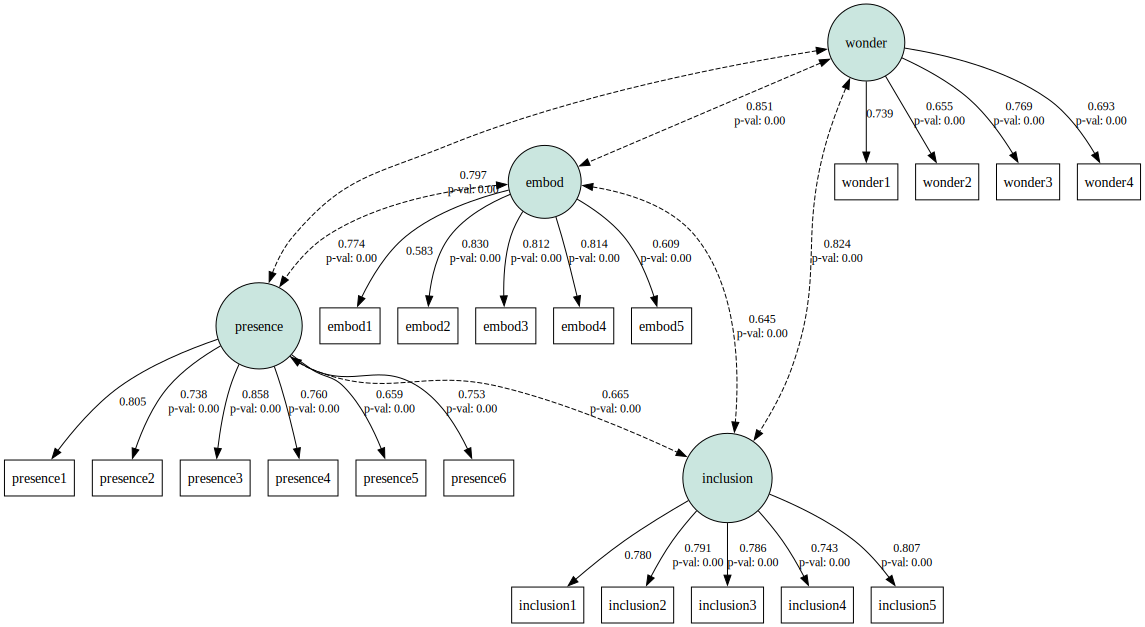

In [8]:
# path diagram
semopy.semplot(
    mod=model,
    plot_covs=True,
    std_ests=True,
    filename="plots/cfa_model_plot_first_order.png",
)

In [9]:
# Save out an html report for the CFA
semopy.report(model=model, name="ETS Scale First Order", std_est=True)

# Additional stats 
I also used an R package in my code because it gives some more stats. It's not my primary coding language, but it can be ran from within Python for things like this. It's output isn't as nice as thee main package I used above, but it got us an confidence interval around RMSEA. It has some additional stats you can explore as well if interested, especially for the loadings. 

In [10]:
import rpy2.robjects as robjects
from rpy2.robjects import ListVector, pandas2ri
from rpy2.robjects.packages import importr

# Import lavaan package from R
lavaan = importr("lavaan")

# Assuming your data is in a pandas DataFrame called 'df_cfa'
# and you have your CFA model specification as a string 'model_spec'

try:
    pandas2ri.activate()
    # Fit the CFA model using lavaan - now should handle pandas DataFrame
    fit = lavaan.cfa(model_spec, data=df_model)

    # Get model summary and fit indices
    summary_output = robjects.r.summary(fit, standardized=True)
    print("Summary Output")
    print(summary_output)

    # Get standardized parameter estimates
    std_estimates = robjects.r.parameterEstimates(fit, standardized=True)
    print("Standardized Estimates")
    print(std_estimates)

    # **Get fit measures with RMSEA CI and p-values for close/not-close fit**
    fm_args_dict = {
        "rmsea.ci.level": robjects.FloatVector([0.95]),
    }  # 95% CI for RMSEA
    fm_args_r_list = ListVector(fm_args_dict)  # Convert Python dict to R list

    # Get fit measures with fm.args as R list
    fit_measures_r_vector = robjects.r.fitMeasures(fit, fm_args=fm_args_r_list)

    # Access RMSEA, CI Bounds, and p-values by INDEX (indices might need verification)
    rmsea_index = 22  # Index for RMSEA point estimate (verified)
    rmsea_lower_95_index = 23  # Index for RMSEA 95% CI lower bound (verified)
    rmsea_upper_95_index = 24  # Index for RMSEA 95% CI upper bound (verified)

    # **Hypothesized indices for RMSEA p-values - NEED VERIFICATION**
    rmsea_pvalue_close_index = (
        25  # <--- HYPOTHESIZED INDEX for p-value of close fit test
    )
    rmsea_pvalue_notclose_index = (
        26  # <--- HYPOTHESIZED INDEX for p-value of not-close fit test
    )

    rmsea = fit_measures_r_vector[rmsea_index]
    rmsea_lower_95 = fit_measures_r_vector[rmsea_lower_95_index]
    rmsea_upper_95 = fit_measures_r_vector[rmsea_upper_95_index]
    rmsea_pvalue_close = fit_measures_r_vector[
        rmsea_pvalue_close_index
    ]  # Extract p-value for close fit
    rmsea_pvalue_notclose = fit_measures_r_vector[
        rmsea_pvalue_notclose_index
    ]  # Extract p-value for not-close fit

    print(f"\nExtracted Fit Indices (with 95% RMSEA CI and p-values):")
    print(f"RMSEA (Index {rmsea_index}): {rmsea:.4f}")
    print(f"RMSEA 95% CI Lower (Index {rmsea_lower_95_index}): {rmsea_lower_95:.4f}")
    print(f"RMSEA 95% CI Upper (Index {rmsea_upper_95_index}): {rmsea_upper_95:.4f}")

except Exception as e:
    print(f"Error during lavaan CFA: {e}")

finally:
    pandas2ri.deactivate()  # Deactivate pandas2ri conversion after use (good practice)

Summary Output
lavaan 0.6-19 ended normally after 43 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        46

  Number of observations                           358

Model Test User Model:
                                                      
  Test statistic                               452.095
  Degrees of freedom                               164
  P-value (Chi-square)                           0.000

Parameter Estimates:

  Standard errors                             Standard
  Information                                 Expected
  Information saturated (h1) model          Structured

Latent Variables:
                   Estimate  Std.Err  z-value  P(>|z|)   Std.lv  Std.all
  inclusion =~                                                          
    inclusion1        1.000                               0.914    0.780
    inclusion2        1.058    0.067   15.75